In [5]:
from tqdm import tqdm
from keras.layers import Input
from keras.models import Model, Sequential, model_from_json 
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import os
import numpy as np

np.random.seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import keras
import matplotlib
print(keras.__version__)
print(matplotlib.__version__)

2.2.4
3.1.0


In [ ]:
folder = '../input/anime-faces/data/data'
l = os.listdir(folder)

train_data = []

for i in l[:20000]:
    try:
        # 로드
        src = cv2.imread(folder+"/"+i, cv2.IMREAD_COLOR)
        # 흑백
        dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        # 사이즈
#         dst = cv2.resize(dst, dsize=(50, 50), interpolation=cv2.INTER_AREA)
        train_data.append(dst.reshape(64*64))
    except:
        continue

train_data = np.array(train_data)
train_data = (train_data.astype(np.float32) - 127.5)/127.5
print(train_data.shape)

In [6]:
class GANs():
    
    def __init__(self):
        
        self.random_dim = 100
        
        self.image_size = (64,64)
        
        self.generator = Sequential()
        self.discriminator = Sequential()
        
        # 우리의 GAN 네트워크를 만듭니다.
        self.set_generator()
        self.set_discriminator()
        
        self.discriminator.trainable = False
        
        # placeholder
        gan_input = Input(shape=(self.random_dim,))
        
        # 생성
        X = self.generator(gan_input)
        
        # 검출
        gan_output = self.discriminator(X)
        
        # 최종 모델 생성
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    
    def load(self, gm, gw, dm, dw, ganm, ganw):

        json_file = open(str(gm), "r") 
        loaded_model_json = json_file.read() 
        json_file.close() 
        self.generator = model_from_json(loaded_model_json)
        self.generator.load_weights(gw) 

        json_file = open(dm, "r") 
        loaded_model_json = json_file.read() 
        json_file.close() 
        self.discriminator = model_from_json(loaded_model_json)
        self.discriminator.load_weights(dw) 
        
        json_file = open(ganm, "r") 
        loaded_model_json = json_file.read() 
        json_file.close() 
        self.gan = model_from_json(loaded_model_json)
        self.gan.load_weights(ganw) 
        
        # __init__
        self.set_generator_compile()
        self.set_discriminator_compile()
        
        self.discriminator.trainable = False
        
        # placeholder
        gan_input = Input(shape=(self.random_dim,))
        
        # 생성
        X = self.generator(gan_input)
        
        # 검출
        gan_output = self.discriminator(X)
        
        # 최종 모델 생성
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    def train(self, epochs=1, batch_size=128):
        
        batch_count = train_data.shape[0] // batch_size
        
        for e in range(1, epochs+1):
            if e == 1 or e % 10 == 0:
                print('-'*15, 'Epoch %d' % e, '-'*15)
            for _ in tqdm(range(batch_count)):
                # random noise 생성
                noise = np.random.normal(0, 1, size=[batch_size, self.random_dim])

                image_batch = train_data[np.random.randint(0, train_data.shape[0], size=batch_size)]

                # image predict
                generated_images = self.generator.predict(noise)
                X = np.concatenate([image_batch, generated_images])

                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9

                # train discriminator
                self.discriminator.trainable = True
                self.discriminator.train_on_batch(X, y_dis)

                # train generator
                noise = np.random.normal(0, 1, size=[batch_size, self.random_dim])
                y_gen = np.ones(batch_size)
                self.discriminator.trainable = False
                self.gan.train_on_batch(noise, y_gen)
            if e == 1 or e % 20 == 0:
                self.plot_generated_images(e)
    
    # Generator
    def set_generator(self):
        self.generator.add(Dense(512, input_dim=self.random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        self.generator.add(LeakyReLU(0.2))

        self.generator.add(Dense(1024))
        self.generator.add(LeakyReLU(0.2))

        self.generator.add(Dense(2048))
        self.generator.add(LeakyReLU(0.2))
        
        self.generator.add(Dense(3072))
        self.generator.add(LeakyReLU(0.2))
        
        self.generator.add(Dense(4096))
        self.generator.add(LeakyReLU(0.2))

        self.generator.add(Dense(64*64, activation='tanh'))
        self.set_generator_compile()
        
    def set_generator_compile(self):
        self.generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    # Discriminator
    def set_discriminator(self):
        self.discriminator.add(Dense(4096, input_dim=64*64, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(Dropout(0.3))

        self.discriminator.add(Dense(3072))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(Dropout(0.3))
        
        self.discriminator.add(Dense(2048))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(Dropout(0.3))
        
        self.discriminator.add(Dense(1024))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(Dropout(0.3))

        self.discriminator.add(Dense(512))
        self.discriminator.add(LeakyReLU(0.2))
        self.discriminator.add(Dropout(0.3))

        self.discriminator.add(Dense(1, activation='sigmoid'))
        self.set_discriminator_compile()
    
    def set_discriminator_compile(self):
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    # train 중 image 검사
    def plot_generated_images(self, epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
        noise = np.random.normal(0, 1, size=[examples, self.random_dim])
        generated_images = self.generator.predict(noise)
        generated_images = generated_images.reshape(examples, self.image_size[0], self.image_size[1])

        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
     
    # noise 생성
    def create_noise(self, examples=100):
        noise = np.random.normal(0, 1, size=[examples, self.random_dim])
        return noise
    
    # predict 값 반환
    def generater_predict(self, noise):
        generated_images = self.generator.predict(noise)
        generated_images = generated_images.reshape(noise.shape[0], self.image_size[0], self.image_size[1])
        return generated_images
    
    # 모델 내보내기
    def output_model(self, pre, name):
        
        model_json = self.generator.to_json()
        with open(pre+"generator"+name+".json", "w") as json_file : 
            json_file.write(model_json)
        
        model_json = self.discriminator.to_json()
        with open(pre+"discriminator"+name+".json", "w") as json_file : 
            json_file.write(model_json)
        
        model_json = self.gan.to_json()
        with open(pre+"gan_"+name+".json", "w") as json_file : 
            json_file.write(model_json)
            
        self.generator.save_weights(pre+"generator_weight"+name+".h5")
        self.discriminator.save_weights(pre+"discriminator_weight"+name+".h5")
        self.gan.save_weights(pre+"gan_weight_"+name+".h5")
        

In [7]:
gans = GANs()
gans.load("generator.json", "generator_weight.h5", "discriminator.json", "discriminator_weight.h5", "gan.json", "gan_weight.h5")

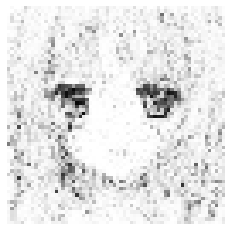

In [8]:
fig = plt.figure()
plt.axis('off')
noise = np.zeros((1,100))
p = gans.generater_predict(noise)

r = p.reshape((1,64,64))[0]

im=plt.imshow(r, cmap='gray')

def init():
    im.set_data(r)
    return [im]

a = gans.create_noise(1)
b = np.zeros((1,100))  
  
def animate(i):
    global a, b
    x = np.linspace(0, np.pi, 100)
    
    b = a * np.sin(2 * np.pi * (x - 0.02 * i))*np.cos(1 * np.pi * (x - 0.01 * i))*0.7+0.2
    
    p = gans.generater_predict(b)
    r = p.reshape((1,64,64))[0]
    
    im.set_array(r)
    return [im]
  
anim_s = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)
anim_s.save('animation_sin.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
HTML(anim_s.to_html5_video())